In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

# Stay classification: cluster-splitting with box-refinement & shifting boxes

## Current evaluation

### Pros
* can separate sequence and identify rudimentary clusters

### Cons
* can't distinguish stays from travels 
    * nothing created to do so.

## ToDos

* check that the newly split clusters are 
    * contain enough samples
    * have a total duration longer than the threshold
    * are not embedded within another cluster
* check that there are no embedded clusters
    * times don't overlap $\checkmark\to$ have function
    * if refined clusters are embedded, check if one cluster is noise
* check the stddev of the refined clusters are smaller


## Future directions

It may be best to use this as an initial pass for the box, or _any_, method, thereby confining the errors and speeding up the compute.

In [3]:
import numpy as np
import pandas as pd

In [10]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [11]:
# #############################################################################
%matplotlib inline
import matplotlib.pyplot as plt

In [12]:
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 10)]

from random import shuffle

In [13]:
shuffle(colors)

# Sythetic data

In [14]:
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
from synthetic_data.trajectory_class import get_rand_traj
from synthetic_data.plotting import plot_trajectory


event_frac = 0.01 #rand_range(1,0.01,0.001)[0]
duplicate_frac = 0.0 #rand_range(1,0.3,0.05)[0]

configs = {
    'time_thresh':1/6,
    'dist_thresh':0.5,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.02,
    'noise_max':0.15
}

/home/sandm/Notebooks/stay_classification/src/synthetic_data/trajectory.py:159: UserWarning: the distance between the consecutive locations is within the threshold 0.5
  warnings.warn(f"the distance between the consecutive locations is within the threshold {dist_thresh}")


<Figure size 1440x720 with 0 Axes>

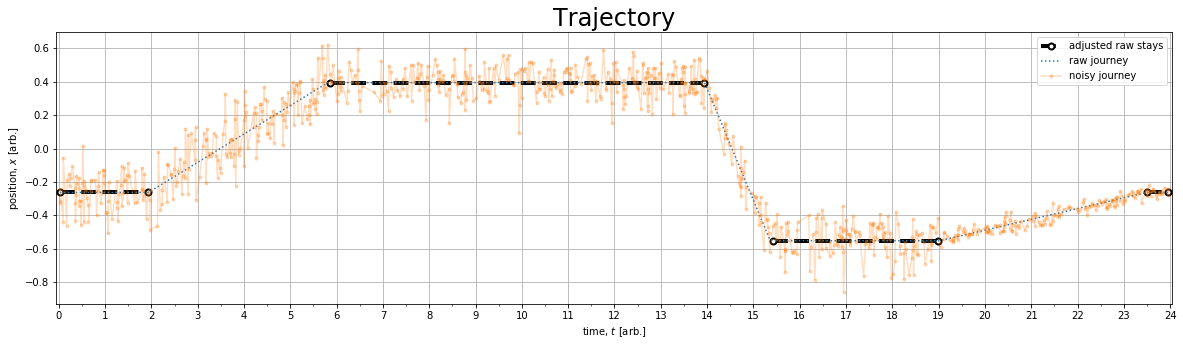

In [17]:
time_arr, raw_arr, noise_arr, segments = get_rand_traj(configs)
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))

plt.figure(figsize=(20,10))
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

# Clustering

## Split the clusters which have a temporal gap

In [18]:
time_thresh = 1/6
dist_thresh=0.25

In [19]:
clusters = list(range(time_arr.size))

In [20]:
from stay_classification.splitting_classifier.splitting_classifier import get_clusters

### Basic cluster identification

In [21]:
clusters = get_clusters(time_arr, noise_arr, dist_thresh, time_thresh)
len(clusters)

17

In [23]:
from helper__metric_box__explore import iqr_metrics, get_boxplot_quants, get_clusters_rev, get_boxplot_centers, get_iqr_mask

In [24]:
clusters_rev = get_clusters_rev(time_arr[::-1], noise_arr[::-1], dist_thresh, time_thresh)
len(clusters_rev)

13

### IQR-plotting

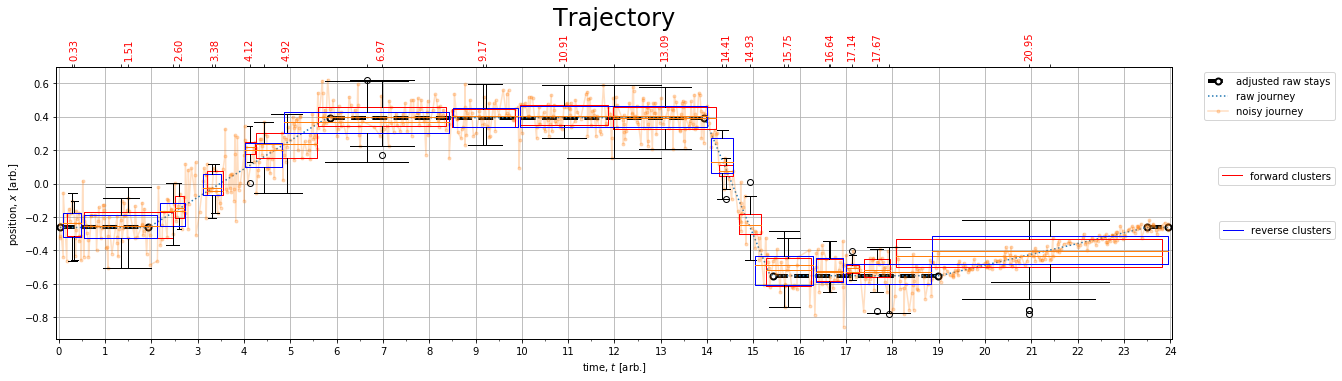

In [27]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

bp_data, labels, positions, widths = get_boxplot_quants(time_arr, noise_arr, clusters)

axt = ax.twiny()
_ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='red'), widths=widths)   

for label in axt.get_xticklabels():
    label.set_rotation(90)
axt.set_xticklabels(labels, visible=True, color='red')


axt.set_xlim(ax.get_xlim())
axt.legend(['forward clusters'], bbox_to_anchor=(1.15, 0.6), loc='center right', ncol=1);


bp_data, labels, positions, widths = get_boxplot_quants(time_arr[::-1], noise_arr[::-1], clusters_rev)

axt = ax.twiny()
labels = list(map(lambda x: f"{x:.2f}", positions))
_ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='blue'), widths=widths)
axt.legend(['reverse clusters'], bbox_to_anchor=(1.15, 0.4), loc='center right', ncol=1);

for label in axt.get_xticklabels():
    label.set_rotation(90)
    
axt.set_xticklabels(labels, visible=False)

axt.set_xlim(ax.get_xlim())
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

### Refinement with `box_method`

In [28]:
from stay_classification.box_classifier.box_classify import box_classifier_core
from stay_classification.box_classifier.box_method import get_mask, make_box,get_directional_indices

In [29]:
from collections import Counter

In [30]:
def sample_times(indices,frac=0.8):
    return np.sort(np.random.choice(np.array(indices),int(frac*len(indices)), replace=False)).tolist()
    

In [31]:
configs['slope_time_thresh'] = 0.05
configs['slope_thresh'] = abs(dist_thresh/time_thresh)
configs['count_thresh'] = 10
configs['dist_thresh'] = 0.125

start_ind, last_ind = clusters[0][0], clusters[0][-1]

init_pairs = []
final_pairs = []

for cluster in clusters:
    
    timepoint = time_arr[cluster].mean()
    
    indices = sample_times(range(len(time_arr)),0.99)
    
    start_ind, last_ind, mean, keep = box_classifier_core(time_arr[indices], noise_arr[indices], start_ind, last_ind, timepoint, init_pairs, configs, False)

    if keep:
        final_pairs.append((start_ind, last_ind))
    else:
        continue
    init_pairs.append([cluster[0], cluster[-1]])
    
final_pairs = list(set(final_pairs))
final_pairs

[(1, 130),
 (84, 183),
 (1, 131),
 (165, 516),
 (539, 794),
 (181, 513),
 (539, 793),
 (181, 514),
 (536, 804),
 (142, 513),
 (515, 530),
 (142, 512),
 (538, 793),
 (182, 512),
 (524, 547),
 (1, 127)]

In [32]:
mid_pairs = []

for cluster in clusters:
    
    timepoint = time_arr[cluster].mean()
    
    # Get a box for a given timepoint
    mean, start_ind, last_ind = make_box(time_arr, noise_arr, timepoint, configs, False)
            
    mid_pairs.append([start_ind, last_ind,])

mid_pairs

[[1, 141],
 [1, 141],
 [1, 141],
 [75, 194],
 [135, 529],
 [135, 529],
 [174, 529],
 [135, 529],
 [174, 529],
 [174, 529],
 [512, 545],
 [520, 564],
 [533, 813],
 [540, 813],
 [540, 813],
 [537, 813],
 [537, 813]]

`for m in range(len(final_pairs)):
    for n in range(m,len(final_pairs)):
        s1 = set(list(range(final_pairs[m][0],final_pairs[m][1]+1)))
        s2 = set(list(range(final_pairs[n][0],final_pairs[n][1]+1)))
        print(s1.isdisjoint(s2))`

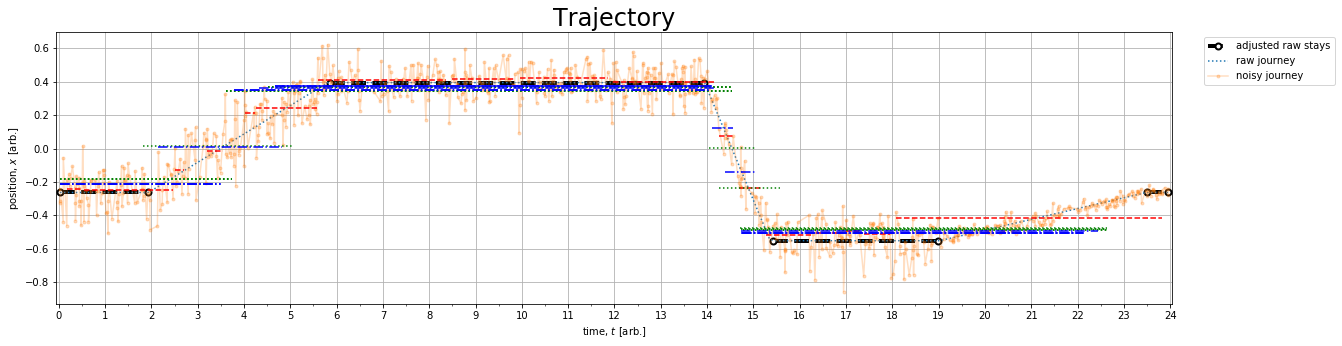

In [33]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

for pair in init_pairs:
    t0, t1 = time_arr[pair[0]], time_arr[pair[-1]]
    mean = np.mean(noise_arr[pair[0]:pair[-1]+1])+.01
    #print(t0,t1,mean)
    ax.plot([t0, t1],[mean,mean], 'r--')

for pair in mid_pairs:
    t0, t1 = time_arr[pair[0]], time_arr[pair[-1]]
    mean = np.mean(noise_arr[pair[0]:pair[-1]+1])
    #print(t0,t1,mean)
    ax.plot([t0, t1],[mean,mean], 'g:')
    
for pair in final_pairs:
    t0, t1 = time_arr[pair[0]], time_arr[pair[-1]]
    mean = np.mean(noise_arr[pair[0]:pair[-1]+1])-.01
    #print(t0,t1,mean)
    ax.plot([t0, t1],[mean,mean], 'b-.')
    
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

In [34]:
pairs_dur = {}
for p in final_pairs:
    dt = time_arr[p[-1]]-time_arr[p[0]]
    
    pairs_dur[tuple(p)] = dt

In [35]:
pairs_dur = {k: v for k, v in sorted(pairs_dur.items(), key=lambda item: item[1], reverse=True)}

In [36]:
pairs_dur

{(142, 513): 10.316944444444445,
 (142, 512): 10.275555555555556,
 (165, 516): 9.842222222222222,
 (181, 514): 9.44138888888889,
 (181, 513): 9.428055555555556,
 (182, 512): 9.233888888888888,
 (536, 804): 7.704722222222221,
 (539, 794): 7.378055555555555,
 (538, 793): 7.373611111111112,
 (539, 793): 7.364722222222223,
 (1, 131): 3.466111111111111,
 (1, 130): 3.4544444444444444,
 (1, 127): 3.3780555555555556,
 (84, 183): 2.673055555555556,
 (524, 547): 0.6650000000000009,
 (515, 530): 0.45333333333333314}

### Shifting boxes

In [37]:
from synthetic_data.trajectory import get_stay_indices

true_indices = get_stay_indices(get_adjusted_stays(segments, time_arr), time_arr)
true_labels = np.zeros(time_arr.shape)

for pair in true_indices:
    true_labels[pair[0]:pair[1]+1] = 1

In [38]:
final_pairs = sorted(final_pairs, key = lambda x: x[0])

In [39]:
def get_box_indices(arr, lower, upper):
    return np.where(((arr > lower) & (arr < upper)))

In [40]:
def shift_box(t_arr, x_arr, dist_thresh=None):

    def meth(pair, shift):
        
        x_arr_ = noise_arr[pair[0]:pair[1]+1]
        t_arr_ = time_arr[pair[0]:pair[1]+1]

        mean_ = x_arr_.mean()

        t0,t1 = t_arr_[0],t_arr_[-1]    

        shift = (t1-t0)/8
        mask_n = get_box_indices(t_arr_, t_arr_[0]-shift, t_arr_[-1]-shift)
        mask_p = get_box_indices(t_arr_, t_arr_[0]+shift, t_arr_[-1]+shift)

        x_arr_n = x_arr_[mask_n]
        t_arr_n = t_arr_[mask_n]
        x_arr_p = x_arr_[mask_p]  
        t_arr_p = t_arr_[mask_p]        

        mean_mask_n = get_box_indices(x_arr_n, mean_-dist_thresh, mean_+dist_thresh)
        mean_mask_p = get_box_indices(x_arr_p, mean_-dist_thresh, mean_+dist_thresh)       
        
        #return abs(x_arr_[mean_mask_n].mean()-mean_), abs(x_arr_[mean_mask_p].mean()-mean_)
        return (abs(x_arr_n[mean_mask_n].mean()-mean_) < 0.01) & (abs(x_arr_p[mean_mask_p].mean()-mean_) < 0.01)
    
    
    return meth

In [41]:
len(final_pairs)

16

In [42]:
last_pairs = []
n=0
for pair in final_pairs:
    cond = shift_box(time_arr, noise_arr, dist_thresh)(pair, time_thresh/2)
    if cond: last_pairs.append(pair)
    print(n,pair, cond)
    n+=1

0 (1, 130) False
1 (1, 131) False
2 (1, 127) False
3 (84, 183) False
4 (142, 513) False
5 (142, 512) False
6 (165, 516) False
7 (181, 513) False
8 (181, 514) False
9 (182, 512) False
10 (515, 530) False
11 (524, 547) False
12 (536, 804) False
13 (538, 793) True
14 (539, 794) True
15 (539, 793) True


-0.2311213001647445 -0.2010494613446324 -0.2115461113367418


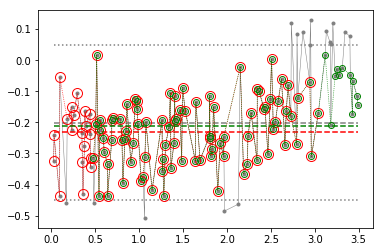

In [46]:
pair = final_pairs[1]

shift = time_thresh/2

x_arr_ = noise_arr[pair[0]:pair[1]+1]
t_arr_ = time_arr[pair[0]:pair[1]+1]

mean_ = x_arr_.mean()

t0,t1 = t_arr_[0],t_arr_[-1]    

shift = (t1-t0)/8
mask_n = get_box_indices(t_arr_, t_arr_[0]-shift, t_arr_[-1]-shift)
mask_p = get_box_indices(t_arr_, t_arr_[0]+shift, t_arr_[-1]+shift)

x_arr_n = x_arr_[mask_n]
t_arr_n = t_arr_[mask_n]
x_arr_p = x_arr_[mask_p]  
t_arr_p = t_arr_[mask_p]        

mean_mask_n = get_box_indices(x_arr_n, mean_-dist_thresh, mean_+dist_thresh)
mean_mask_p = get_box_indices(x_arr_p, mean_-dist_thresh, mean_+dist_thresh)   

plt.plot(t_arr_, x_arr_, '.-', color='gray', lw=0.5)

plt.plot([t_arr_[0],t_arr_[-1]],[mean_,mean_], "--", color='gray', markersize=1)
plt.plot([t_arr_[0],t_arr_[-1]],[mean_+dist_thresh,mean_+dist_thresh], ":", color='gray')
plt.plot([t_arr_[0],t_arr_[-1]],[mean_-dist_thresh,mean_-dist_thresh], ":", color='gray')

#plt.plot(t_arr_n, x_arr_n, 'ro', markerfacecolor="None")
plt.plot(t_arr_n[mean_mask_n], x_arr_n[mean_mask_n], 'ro:', lw=0.7, markerfacecolor="None", markersize=10)
mean_n = x_arr_n[mean_mask_n].mean()
plt.plot([t_arr_[0],t_arr_[-1]],[mean_n,mean_n], "--", color='r', markersize=1)


plt.plot(t_arr_p[mean_mask_p], x_arr_p[mean_mask_p], 'go:', lw=0.7, markerfacecolor="None", markersize=6)
mean_p = x_arr_p[mean_mask_p].mean()
plt.plot([t_arr_[0],t_arr_[-1]],[mean_p,mean_p], "--", color='g', markersize=1)
#print(abs(mean_p-mean_)<0.01,abs(mean_n-mean_)<0.01)
print(mean_n,mean_,mean_p)

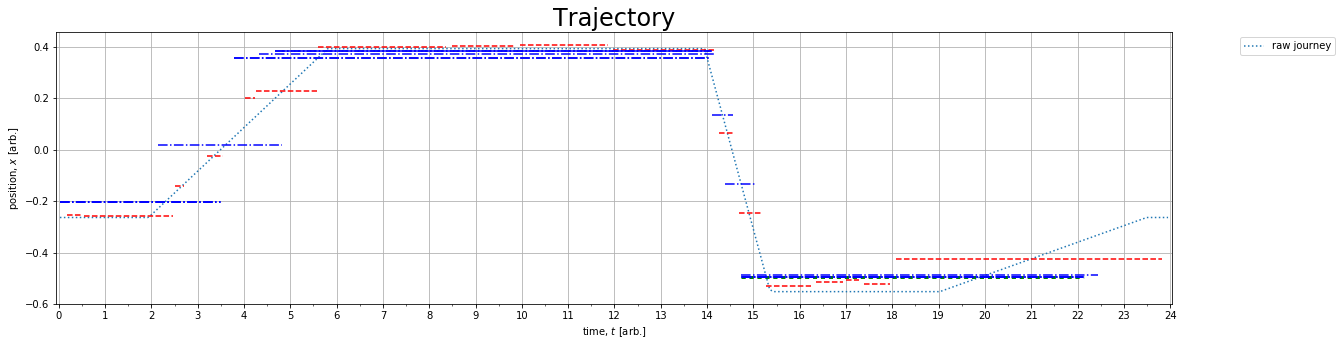

In [47]:
ax = plot_trajectory(time_arr, raw_arr, None, None, None, configs['dist_thresh']);
#'''
for pair in init_pairs:
    t0, t1 = time_arr[pair[0]], time_arr[pair[-1]]
    mean = np.mean(noise_arr[pair[0]:pair[-1]+1])
    #print(t0,t1,mean)
    ax.plot([t0, t1],[mean,mean], 'r--')#'''

for pair in last_pairs:
    t0, t1 = time_arr[pair[0]], time_arr[pair[-1]]
    mean = np.mean(noise_arr[pair[0]:pair[-1]+1])
    #print(t0,t1,mean)
    ax.plot([t0, t1],[mean,mean], 'g:', lw=3)
    
#'''
for pair in final_pairs:
    t0, t1 = time_arr[pair[0]], time_arr[pair[-1]]
    mean = np.mean(noise_arr[pair[0]:pair[-1]+1])
    #print(t0,t1,mean)
    ax.plot([t0, t1],[mean,mean], 'b-.')#'''
    
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

In [79]:
def intersecting_bounds(a1,a2,b1,b2):
    
    return (((a1 >= b1) & (a1 <= b2)) | 
            ((a2 >= b1) & (a2 <= b2)) | 
            ((b1 >= a1) & (b1 <= a2)) | 
            ((b2 >= a1) & (b2 <= a2)))    

In [80]:
inter_bounds = lambda p1, p2: intersecting_bounds(p1[0],p1[-1],p2[0],p2[-1])

In [81]:
intersecting_bounds(1,4,2,3), \
intersecting_bounds(2,3,1,4), \
intersecting_bounds(1,3,2,4), \
intersecting_bounds(2,4,1,3), \
intersecting_bounds(1,2,3,4), \
intersecting_bounds(3,4,1,2)


(True, True, True, True, False, False)

In [82]:
new_last_pairs = []

for m in range(len(last_pairs)):

    n = m+1
    while keep_going
        #for n in range(m+1,len(last_pairs)):
        
        print(last_pairs[m], last_pairs[n])
        
        if inter_bounds(last_pairs[m], last_pairs[n]):
            
            l1 = list(range(last_pairs[m][0],last_pairs[m][1]+1))
            l2 = list(range(last_pairs[n][0],last_pairs[n][1]+1))

            len1 = len(l1)
            len2 = len(l2)        

            s1 = set(l1)
            s2 = set(l2)

            ilen1 = len(list(s1.intersection(s2)))
            ilen2 = len(list(s2.intersection(s1)))

            print(last_pairs[m], len1, last_pairs[n], len2,ilen1,ilen2)
            
            if ilen1/len1 > 0.8:
                new_last_pairs.append(last_pairs[m])
        else:
            new_last_pairs.append(last_pairs[m])
        
        n += 1
                            

SyntaxError: invalid syntax (<ipython-input-82-e2bb16c5f24a>, line 6)

In [83]:
new_last_pairs

NameError: name 'new_last_pairs' is not defined